# Chapter 4 - Hyperparameter Tuning

## In this notebook we will:

  - Connect to your workspace.
  - Create a virtual environment and leverage in this notebook
  - Explore the dataset
  - Data cleansing and analysis work
  - Feature Engineering
  - Register the cleansed data
  - Explore leveraging an MLTable
  - Run a job that leverages
    - sklearn pipeline for data transformation
    - `mlflow.autolog` for capturing *training* and *test* metrics
    - log additional metrics to a given job run
  - download and use a model that is created as a result of the job
  - Use `Sweep` to search for the best hyperparamers for a model

## Setting yourself up for success

- When creating a model, one of the major obstacles is having an environment that has the required dependencies.  We will create and register an AML environment and use on our compute instance.  This will allow us to leverage the model we build on a compute cluster on our compute instance.  The same packages and versions leveraged to build the model will be used to consume the model later in this notebook

Steps to setup our environment include:
- Connecting to our workspace
- Defining and registering the environment
- Making the environment available to our compute instance 
- Making the environment available to our jupyter notebook

Let's get started

Select **Kernel** > **Change Kernel** > **Python 3.10 - SDK V2**

In [1]:
import azure.ai.ml
print(azure.ai.ml._version.VERSION)

1.1.2


In [2]:
#import required libraries
import pandas as pd
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml.entities import Environment, BuildContext

## Connecting to your workspace

Once you connect to your workspace, you will create a new cpu target which you will provide an environment to.

- We should be able to connect with the MLClient using your credentials in the config of the compute instance.  You should not keep your subscription id, resource group or workspace name visible in your code

In [3]:
subscription_id = ""
resource_group =  ""
workspace =  ""
        

ml_client = MLClient(
    DefaultAzureCredential(), subscription_id, resource_group, workspace
)

## Setup enviroment

### Creating environment from docker image with a conda YAML

Azure ML allows you to leverage curated environments, as well as to build your own environment from:

    - existing docker image
    - base docker image with a conda yml file to customize
    - a docker build content
    
We will proceed with creating an environment from a docker build plus a conda yml file.

In [4]:
import os
script_folder = os.path.join(os.getcwd(), "conda-yamls")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/conda-yamls


### Create job environment in a yml file

- At the time of writing this, the versions of `mlflow`, `azure-ai-ml` `mltable` and `azureml-mlflow` where set accordingly below.  They have been set to ensure stability of the notebook, but please update them according to the lastest package versions.

In [5]:
%%writefile conda-yamls/job_env.yml
name: job_env
dependencies:
- python=3.10
- scikit-learn=1.1.3
- ipykernel
- matplotlib
- pandas
- pip
- pip:
  - mlflow==2.0.1
  - azure-ai-ml==1.1.2
  - mltable==1.0.0
  - azureml-mlflow==1.48.0

Overwriting conda-yamls/job_env.yml


### Getting the most current and up-to-date base image

Default images are always changing.  
Note the base image is defined in the property `image` below.  These images are defined at [https://hub.docker.com/_/microsoft-azureml](https://hub.docker.com/_/microsoft-azureml)

The current image we have selected for this notebook is `mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04`, but based on image availability, that will change in the future.  In additon, note the python version specified in your conda environment file is `python=3.10`, as this will evolve over time as well. 

In [6]:
env_docker_conda = Environment(
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04",
    conda_file="conda-yamls/job_env.yml",
    name="job_base_env",
    description="Environment created from a Docker image plus Conda environment.",
)
ml_client.environments.create_or_update(env_docker_conda)

Environment({'is_anonymous': False, 'auto_increment_version': False, 'name': 'job_base_env', 'description': 'Environment created from a Docker image plus Conda environment.', 'tags': {}, 'properties': {}, 'id': '/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourceGroups/aml-dev-rg/providers/Microsoft.MachineLearningServices/workspaces/aml-ws/environments/job_base_env/versions/2', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fc7ac57af80>, 'serialize': <msrest.serialization.Serializer object at 0x7fc7ac57a170>, 'version': '2', 'latest_version': None, 'conda_file': {'dependencies': ['python=3.10', 'scikit-learn=1.1.3', 'ipykernel', 'matplotlib', 'pandas', 'pip', {'pip': ['mlflow==2.0.1', 'azure-ai-ml==1.1.2', 'mltable==1.0.0', 'azureml-mlflow==1.48.0']}], 'name': 'job_env'}, '

### Use your virtual environment in this notebook

We can actually use that virtual environment on our compute instance and in this very jupyter notebook.
Open a terminal session, and and run the following commands:

```
cd Azure-Machine-Learning-Engineering/
cd 'Chapter04'
cd conda-yamls/
conda env create -f job_env.yml
conda activate job_env
ipython kernel install --user --name job_env --display-name "job_env"
```
* After the environment has been made available to Jupyter, Refresh this session (F5, or Hit refresh on your browser)

When you go to your `Kernel` -> `Change Kernel`, it will be available to select.  You will have to rerun the notebook, but when you download the model, you will be using all of the correct versions of libraries.

*Note to remove an environment with conda leverage 
```
conda env remove -n job_env
```

# Explore Dataset

You're going to use a Python script to train a machine learning model based on the Titanic datset found in your data folder.  

In [7]:
df= pd.read_csv('./data/titanic.csv')
print(df.shape)
print(df.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## View Data

In [8]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dataset field information

- **PassengerId**: (remove) Should be removed from model as they are some sort of id.
- **Pclass**: (keep) locates folks on ship *Pclass: 1st = Upper, 2nd = Middle, 3rd = Lower*
- **Name**: (remove) maybe found useful if keeping the surname, but for basic model will remove
- **Sex**: (keep) due to lifeboat priority, will likely be useful
- **Age**: (keep)important due to lifeboat priority
- **SibSp**: (keep) maybe useful, relatives will likely help others
- **Parch**: (keep) maybe useful, relatives will likely help others
- **Ticket**: (remove)
- **Fare**: (remove covered by class)
- **Cabin**: (keep) can be useful in relation of where the cabins are positioned on the ship
- **Embarked**: (keep) useful because all listed embark happened before the disaster

# Data Engineering

## Data Cleansing

We will begin by evaluating the null values in the dataset.  Note that Age, Fare and Cabin contain null values in the dataset.

In [9]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

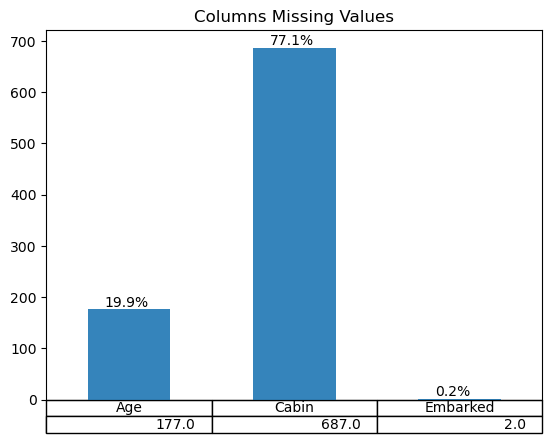

In [10]:
import matplotlib.pyplot as plt

columns_missing = df.isna().sum().where(lambda x : x > 0).dropna()

ax = columns_missing \
.plot(kind='bar', alpha=0.9, title='Columns Missing Values', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

for x in ax.patches:
    ax.text(x.get_x()+.1, x.get_height()+5, \
            str(round((x.get_height()/df.shape[0])*100, 1))+'%')
plt.show()

## Prepare data for an experiment
In the previous notebook, the data was leveraged directly from the folder on the compute instance.  We will be submitting an experiment to a compute cluster, so we will register the dataset so it will be stored in the blob storage associated with the AML workspace

### Stategy:

- For the Age, we will replace the missing values with the medians of each group
- For cabin we will mark it as X given this is probably an important feature that we would want to include.
- For Embarked,given there are only 2 rows missing this value, we will set these to a value of S

## Cleaning Age Column

Note that Age, a column that has missing data, will likely be impacted by class, as people are more established,their age will likely increase, so to replace these values, we will group by class and sex, calculate a median value and replace the na values in the dataset with the mean

In [11]:
display(df.groupby(['Pclass', 'Sex'])['Age'].count())

display(df.groupby(['Pclass', 'Sex'])['Age'].median())

Pclass  Sex   
1       female     85
        male      101
2       female     74
        male       99
3       female    102
        male      253
Name: Age, dtype: int64

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

In [12]:
df['Age'] = df.groupby(['Pclass', 'Sex'],group_keys=False)['Age'].apply(lambda x: x.fillna(x.median()))
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
print(df['Sex'].unique())
df['Sex']= df['Sex'].apply(lambda x: x[0] if pd.notnull(x) else 'X')
print(df['Sex'].unique())

['male' 'female']
['m' 'f']


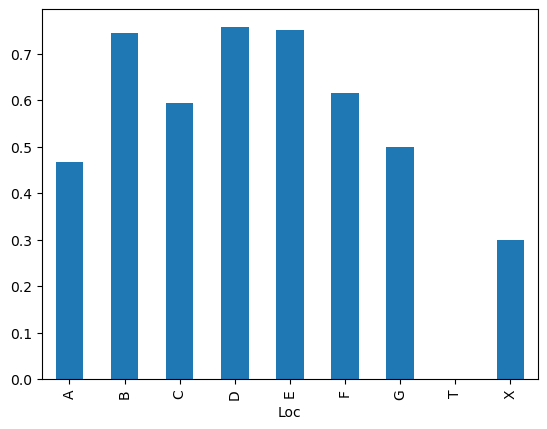

In [14]:
df['Loc']= df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')
df[['Loc', 'Survived']].groupby('Loc')['Survived'].mean().plot(kind= 'bar')
plt.show()


In [15]:
df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [16]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Loc
0,1,0,3,"Braund, Mr. Owen Harris",m,22.0,1,0,7.2500,S,X
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",f,38.0,1,0,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",f,26.0,0,0,7.9250,S,X
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",f,35.0,1,0,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",m,35.0,0,0,8.0500,S,X
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",m,27.0,0,0,13.0000,S,X
887,888,1,1,"Graham, Miss. Margaret Edith",f,19.0,0,0,30.0000,S,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",f,21.5,1,2,23.4500,S,X
889,890,1,1,"Behr, Mr. Karl Howell",m,26.0,0,0,30.0000,C,C


In [17]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
Loc            0
dtype: int64

In [18]:
df['Embarked'] = df['Embarked'].fillna('S')

# Feature Engineering
## Create a Group Size

In [19]:
df.loc[:,'GroupSize'] = 1 + df['SibSp'] + df['Parch']

## Fill Missing Embarded with value of S

In [20]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Loc            0
GroupSize      0
dtype: int64

In [21]:
LABEL = 'Survived'
columns_to_keep = ['Pclass', 'Sex','Age', 'Fare', 'Embared', 'Deck', 'GroupSize']
columns_to_drop = ['Name','SibSp', 'Parch', 'Survived']
df_train = df
df = df_train.drop(['Name','SibSp', 'Parch', 'PassengerId'], axis=1)

df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,m,22.0,7.2500,S,X,2
1,1,1,f,38.0,71.2833,C,C,2
2,1,3,f,26.0,7.9250,S,X,1
3,1,1,f,35.0,53.1000,S,C,2
4,0,3,m,35.0,8.0500,S,X,1


In [22]:
import os
script_folder = os.path.join(os.getcwd(), "prepped_data")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)
df.to_csv('./prepped_data/titanic_prepped.csv', index = False)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/prepped_data


## Working with Data

Data can reside in:

    - Local Machine: URI_FILE, URI_FOLDER, MLTABLE, TRITON_MODEL, CUSTOM_MODEL
    - Web
    - Data Storage Services (Bob, ADSL, SQL)
        - https://<account_name>.blob.core.windows.net/<container_name>/path
        - abfss://<file_system>@<account_name>.dfs.core.windows.net/<path>
        - azureml://datastores/<data_store_name>/paths/<path>

In [23]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

You can register the a csv file directly from the data directory, we are using a csv file in the directory, but you can leverage data from supported cloud storage using `https`, `abfss` and `wasbs` 

### Register a uri_file

In [24]:
try:
    registered_data_asset = ml_client.data.get(name='titanic_prepped', version=1)
    print('data asset is registered')
except:
    print('register data asset')
    my_data = Data(
        path="./prepped_data/titanic_prepped.csv",
        type=AssetTypes.URI_FILE,
        description="Titanic CSV",
        name="titanic_prepped",
        version="1",
    )

    ml_client.data.create_or_update(my_data)

register data asset


Uploading titanic_prepped.csv (< 1 MB): 100%|██████████| 20.6k/20.6k [00:00<00:00, 1.92MB/s]




### Working with an MLTable

`MLTable` are great for:
- when your data is complex
- you only need a subset of the data
- you will leverage dataset with **AutoML** job which requires tabular data

In [25]:
import os
script_folder = os.path.join(os.getcwd(), "titanic_prepped_mltable")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/titanic_prepped_mltable


## Create MLTable Definition file
Note we can exclude columns right in the definition based on the MLTable.schema.json definition

In [26]:
%%writefile titanic_prepped_mltable/MLTable
$schema: https://azuremlschemas.azureedge.net/latest/MLTable.schema.json 

type: mltable
paths:
    - pattern: ./*.csv

transformations:
  - read_delimited:
      delimiter: ","
      header: all_files_same_headers
      encoding: utf8
  - drop_columns: ["Id"]

Writing titanic_prepped_mltable/MLTable


In [27]:
import shutil
data_file = './prepped_data/titanic_prepped.csv'
target   = script_folder + '/titanic_prepped.csv'
shutil.copyfile(data_file, target)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/titanic_prepped_mltable/titanic_prepped.csv'

### Loading an MLTable before registration

You should located the `MLTable` file with the data.  You can load an `MLTable` using the `mltable` library

In [28]:
import mltable

# Note: the uri below can be a local folder or folder located in cloud storage. The folder must contain a valid MLTable file.
script_folder = os.path.join(os.getcwd(), "titanic_prepped_mltable")
print(script_folder)
tbl = mltable.load(uri=script_folder)
tbl.to_pandas_dataframe()

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/titanic_prepped_mltable


,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,False,3,m,22.0,7.2500,S,X,2
1,True,1,f,38.0,71.2833,C,C,2
2,True,3,f,26.0,7.9250,S,X,1
3,True,1,f,35.0,53.1000,S,C,2
4,False,3,m,35.0,8.0500,S,X,1
...,...,...,...,...,...,...,...,...
886,False,2,m,27.0,13.0000,S,X,1
887,True,1,f,19.0,30.0000,S,B,1
888,False,3,f,21.5,23.4500,S,X,4
889,True,1,m,26.0,30.0000,C,C,1


## Register an MLTable

an MLTable can be leveraged as an input to a job or pipeline.  
After it is registered, you can also retrieve it by name.

In [29]:
try:
    registered_data_asset = ml_client.data.get(name='titanic_prepped_mltable_x2', version=1)
    print('retrieved registered data asset')
except:
    print('registering ml table')
    titanic_data = Data(
        name="titanic_prepped_mltable_x2",
        path='./titanic_prepped_mltable/',
        type=AssetTypes.MLTABLE,
        description="Dataset for titanic",
        tags={"source_type": "file", "source": "ML Engineering"},
        version="1",
    )
    titanic_data = ml_client.data.create_or_update(titanic_data)
    print(f"Dataset with name {titanic_data.name} was registered to workspace, the dataset version is {titanic_data.version}")

registering ml table


Uploading titanic_prepped_mltable (0.02 MBs): 100%|██████████| 20861/20861 [00:00<00:00, 622961.08it/s]




Dataset with name titanic_prepped_mltable_x2 was registered to workspace, the dataset version is 1


In [30]:
registered_v1_data_asset = ml_client.data.get(name='titanic_prepped_mltable_x2', version='1')
print(registered_v1_data_asset.path)

tbl = mltable.load(uri=registered_v1_data_asset.path)
tbl.to_pandas_dataframe()

azureml://subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws/datastores/workspaceblobstore/paths/LocalUpload/b3e9d2d76d36b52fc88b17546f0f0460/titanic_prepped_mltable/


,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,False,3,m,22.0,7.2500,S,X,2
1,True,1,f,38.0,71.2833,C,C,2
2,True,3,f,26.0,7.9250,S,X,1
3,True,1,f,35.0,53.1000,S,C,2
4,False,3,m,35.0,8.0500,S,X,1
...,...,...,...,...,...,...,...,...
886,False,2,m,27.0,13.0000,S,X,1
887,True,1,f,19.0,30.0000,S,B,1
888,False,3,f,21.5,23.4500,S,X,4
889,True,1,m,26.0,30.0000,C,C,1


## Create Compute 

In [31]:
from azure.ai.ml.entities import AmlCompute

# specify aml compute name.
cpu_compute_target = "cpu-cluster"

try:
    ml_client.compute.get(cpu_compute_target)
except Exception:
    print("Creating a new cpu compute target...")
    compute = AmlCompute(
        name=cpu_compute_target, size="STANDARD_D2_V2", min_instances=0, max_instances=4, idle_time_before_scale_down = 1800
    )
    ml_client.compute.begin_create_or_update(compute)

Creating a new cpu compute target...


## Creating code to generate Basic Model

We will first create a model using the job command, and then leverage the `jobsweep` command with specified parameters for hyperparameter tuning

In [32]:
script_folder = os.path.join(os.getcwd(), "src")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/src


## Create main.py file for running in your command

In [33]:
%%writefile ./src/main.py
import os
import argparse
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score


# define functions
def main(args):
    current_run = mlflow.start_run()
    mlflow.sklearn.autolog(log_models=False)

    # read in data
    df = pd.read_csv(args.titanic_csv)
    model = model_train('Survived', df, args.randomstate)
    mlflow.end_run()

def model_train(LABEL, df, randomstate):
    print('df.columns = ')
    print(df.columns)
    
    df['Embarked'] = df['Embarked'].astype(object)
    df['Loc'] = df['Loc'].astype(object)
    df['Loc'] = df['Sex'].astype(object)
    df['Pclass'] = df['Pclass'].astype(float)
    df['Age'] = df['Age'].astype(float)
    df['Fare'] = df['Fare'].astype(float)
    df['GroupSize'] = df['GroupSize'].astype(float)

    y_raw           = df[LABEL]
    columns_to_keep = ['Embarked', 'Loc', 'Sex','Pclass', 'Age', 'Fare', 'GroupSize']
    X_raw           = df[columns_to_keep]

    print(X_raw.columns)
     # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=randomstate)
    
    #use Logistic Regression estimator from scikit learn
    lg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    preprocessor = buildpreprocessorpipeline(X_train)
    
    #estimator instance
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lg)], verbose=True)

    model = clf.fit(X_train, y_train)
    
    print('type of X_test = ' + str(type(X_test)))
          
    y_pred = model.predict(X_test)
    
    print('*****X_test************')
    print(X_test)
    
    #get the active run.
    run = mlflow.active_run()
    print("Active run_id: {}".format(run.info.run_id))

    acc = model.score(X_test, y_test )
    print('Accuracy:', acc)
    MlflowClient().log_metric(run.info.run_id, "test_acc", acc)
    
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' , auc)
    MlflowClient().log_metric(run.info.run_id, "test_auc", auc)
    
    
    # Signature
    signature = infer_signature(X_test, y_test)

    # Conda environment
    custom_env =_mlflow_conda_env(
        additional_conda_deps=["scikit-learn==1.1.3"],
        additional_pip_deps=["mlflow<=1.30.0"],
        additional_conda_channels=None,
    )

    # Sample
    input_example = X_train.sample(n=1)

    # Log the model manually
    mlflow.sklearn.log_model(model, 
                             artifact_path="model", 
                             conda_env=custom_env,
                             signature=signature,
                             input_example=input_example)


    
    return model



def buildpreprocessorpipeline(X_raw):

    categorical_features = X_raw.select_dtypes(include=['object', 'bool']).columns
    numeric_features = X_raw.select_dtypes(include=['float','int64']).columns

    #categorical_features = ['Sex', 'Embarked', 'Loc']
    categorical_transformer = Pipeline(steps=[('onehotencoder', 
                                               OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))])


    #numeric_features = ['Pclass', 'Age', 'Fare', 'GroupSize']    
    numeric_transformer1 = Pipeline(steps=[('scaler1', SimpleImputer(missing_values=np.nan, strategy = 'mean'))])
    

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric1', numeric_transformer1, numeric_features),
            ('categorical', categorical_transformer, categorical_features)], remainder='drop')
    
    return preprocessor



def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--titanic-csv", type=str)
    parser.add_argument("--randomstate", type=int, default=42)

    # parse args
    args = parser.parse_args()
    print(args)
    # return args
    return args


# run script
if __name__ == "__main__":
    # parse args
    args = parse_args()

    # run main function
    main(args)

Writing ./src/main.py


## Configure Command

- `display_name` display name for the job
- `description`  the description of the experiment
- `code` path where the code is located
- `command` command to run
- `inputs`  dictionary of name value pairs using `${{inputs.<input_name>}}`
    
    - To use files or folder - using the `Input` class
        
        - `type` defaults to a `uri_folder` but this can be set to `uri_file` or `uri_folder`
        - `path` is the path to the file or folder.  These can be local or remote leveraging **https, http, wasb`
        
            - To use an Azure ML dataset, this would be an Input `Input(type='uri_folder', path='my_dataset:1')`
            
            - `mode` is how the data should be delivered to the compute which include `ro_mount`(default), `rw_mount` and `download`

- `environment`: environment to be used by compute when running command
- `compute`: can be `local`, or a specificed compute name
- `distribution`: distribution to leverage for distributed training scenerios including:
        
    - `Pytorch`
    - `TensorFlow`
    - `MPI`
            
            
          

In [34]:
# create the command
from azure.ai.ml import command
from azure.ai.ml import Input

my_job = command(
    code="./src",  # local path where the code is stored
    command="python main.py --titanic ${{inputs.titanic}} --randomstate ${{inputs.randomstate}}",
    inputs={
        "titanic": Input(
            type="uri_file",
            path="azureml:titanic_prepped:1",
        ),
        "randomstate": 0,
    },
    environment="job_base_env@latest",
    compute="cpu-cluster",
    display_name="sklearn-titanic",
    # description,
    # experiment_name
)

In [35]:
script_folder = os.path.join(os.getcwd(), "job")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/job


## Run Command with SDK

In [36]:
# submit the command
returned_job = ml_client.create_or_update(my_job)

Uploading src (0.0 MBs): 100%|██████████| 4595/4595 [00:00<00:00, 577134.42it/s]




In [37]:
returned_job.services["Studio"].endpoint

'https://ml.azure.com/runs/amiable_corn_pbqpr5tvxf?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

In [38]:
returned_job

Experiment,Name,Type,Status,Details Page
Chapter04,amiable_corn_pbqpr5tvxf,command,Starting,Link to Azure Machine Learning studio


In [39]:
run_id = returned_job.name
print('run_id:' + run_id)
experiment = returned_job.experiment_name
print("experiment:" + experiment)

run_id:amiable_corn_pbqpr5tvxf
experiment:Chapter04


You can always get the list of runs using ml flow.  Below we will track our process:

In [40]:
import mlflow
import time

exp = mlflow.get_experiment_by_name(experiment)
last_run = mlflow.search_runs(exp.experiment_id, output_format="list")[-1]

if last_run.info.run_id != run_id:
    print('run ids were not the same - waiting for run id to update')
    time.sleep(5)
    exp = mlflow.get_experiment_by_name(experiment)
    last_run = mlflow.search_runs(exp.experiment_id, output_format="list")[-1]

while last_run.info.status == 'SCHEDULED':
  print('run is being scheduled')
  time.sleep(5)
  last_run = mlflow.search_runs(exp.experiment_id, output_format="list")[-1]

while last_run.info.status == 'RUNNING':
  print('job is being run')
  time.sleep(10)
  last_run = mlflow.search_runs(exp.experiment_id, output_format="list")[-1]

print("run_id:{}".format(last_run.info.run_id))
print('----------')
print("run_id:{}".format(last_run.info.status))

job is being run
job is being run
job is being run
run_id:amiable_corn_pbqpr5tvxf
----------
run_id:FINISHED


## Create a job.yml file

Note you can also run a command through the CLI.  This is great preperation for MLOps. The file below will allow use to leverage the AML CLI V2 to run this command.  We can and will run it through the CLI, but it is included here for completeness

In [41]:
%%writefile ./job/job.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
code: ../src
command: >-
  python main.py 
  --titanic-csv ${{inputs.titanic}}
  --randomstate ${{inputs.randomstate}}
inputs:
  titanic:
    type: uri_file
    path: azureml:titanic_prepped:1
    mode: ro_mount
  randomstate: 0   
environment: azureml:job_base_env@latest
compute: azureml:cpu-cluster
experiment_name: titanic-job-example
description: | 
    # Train a classification model on titanic data using a registered dataset as input.


Writing ./job/job.yml


You can use the CLI to run this command now that you have created a yml file.  Navigate on your compute instance to the folder holding the job.yml file (this is the job folder inside the Chapter04 folder) and run the following command in the terminal.

* Note to replace the workspace name in the command with your workspace name (update the value: aml-workspace), and the resource group (update the value: aml-workspace-rg) with your resource group name

```
az login
az ml job create --file job.yml --web --resource-group aml-workspace-rg --workspace-name aml-workspace
```


### List all of the artifacts that were automatically logged as part of your experiment

In [42]:
import mlflow

print(experiment)
print(run_id)
mlflow.set_experiment(experiment_name=experiment)
client = mlflow.tracking.MlflowClient()
client.list_artifacts(run_id=run_id)

Chapter04
amiable_corn_pbqpr5tvxf


[<FileInfo: file_size=-1, is_dir=False, path='estimator.html'>,
 <FileInfo: file_size=-1, is_dir=True, path='model'>,
 <FileInfo: file_size=-1, is_dir=True, path='system_logs'>,
 <FileInfo: file_size=-1, is_dir=False, path='training_confusion_matrix.png'>,
 <FileInfo: file_size=-1, is_dir=False, path='training_precision_recall_curve.png'>,
 <FileInfo: file_size=-1, is_dir=False, path='training_roc_curve.png'>,
 <FileInfo: file_size=-1, is_dir=True, path='user_logs'>]

You can download any artifact from the list of artifacts - and display the results

/tmp/ipykernel_285738/3405485479.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  file_path = client.download_artifacts(


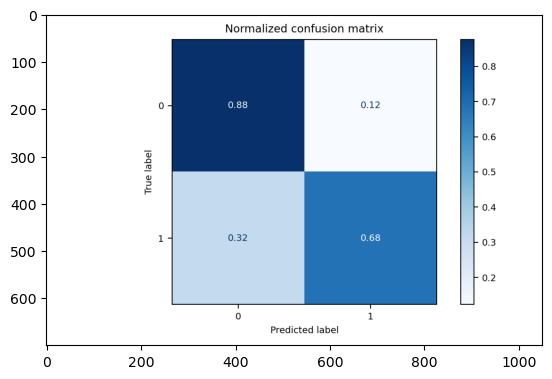

In [43]:
file_path = client.download_artifacts(
    run_id, path="training_confusion_matrix.png"
)

import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread(file_path)
plt.imshow(image)
plt.show()

### Retrieve the Model and consume locally

Given the model was already logged as a job artifact, we can download it locally and run it.  
  



In [44]:
print(last_run.info.run_id)
pipeline_model = mlflow.sklearn.load_model(f"runs:/{last_run.info.run_id}/model")

amiable_corn_pbqpr5tvxf


In [45]:
type(pipeline_model)

sklearn.pipeline.Pipeline

In [46]:
script_folder = os.path.join(os.getcwd(), "titanic_prepped_mltable")
print(script_folder)
tbl = mltable.load(uri=script_folder)
df  = tbl.to_pandas_dataframe()
columns_to_keep =  ['Embarked', 'Loc', 'Sex','Pclass', 'Age', 'Fare', 'GroupSize']
X_raw           = df[columns_to_keep]


/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/titanic_prepped_mltable


In [47]:
results = pipeline_model.predict(X_raw)
print(results)

[0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 

### Register the Model 

Using the Python SDK V2 - we can register the Model for use.  

Parameters for model registration include:

- `path` - A remote uri or local path pointing at the model
- `name` - A string value
- `description` - A description for the model
- `type` - valid values include: 
    - "custom_model"
    - "mlflow_model" 
    - "triton_model".  
    
* Instead of typing out the `type`, you can use the AssetTypes in the namespace azure.ai.ml.constants as we have done below




In [48]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

run_model = Model(
    path=f"runs:/{last_run.info.run_id}/model",
    name="titanic_model",
    description="Model created from run.",
    type=AssetTypes.MLFLOW_MODEL 
)

ml_client.models.create_or_update(run_model) 

Model({'job_name': 'amiable_corn_pbqpr5tvxf', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'titanic_model', 'description': 'Model created from run.', 'tags': {}, 'properties': {}, 'id': '/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourceGroups/aml-dev-rg/providers/Microsoft.MachineLearningServices/workspaces/aml-ws/models/titanic_model/versions/1', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fc72c322200>, 'serialize': <msrest.serialization.Serializer object at 0x7fc72c3218d0>, 'version': '1', 'latest_version': None, 'path': 'azureml://subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourceGroups/aml-dev-rg/workspaces/aml-ws/datastores/workspaceartifactstore/paths/ExperimentRun/dcid.amiable_corn_pbqpr5tvxf/model', 'datastore': None, 'utc_time_create

## Hyperparameter Sweep

Configure your experiment to tune your hyperparameters.  The parameters can be discrete or continuous values.

### Sweep Function
The Sweep Function allows you to define:

  - for the job `sampling_algorithm` to be 
    - random
    - grid
    - bayesian
  - `objective`: 
    - primary_metric - the metric must be loggin the the training script using mflow.log_metric()
    - goal - the optimzation goal of the objective.primary_metric
      - maximize
      - minimize
  - `compute` - name of the compute target to excute the job on
  - `limits` - limits for the sweep job

The **Best Child Run** on the Overview screen will show you the best performing child run.

## Update Script to take hyperparameters

We will update the script a bit, and now take in hyperparameters.

```
parser.add_argument("--penalty-term", type=str, default='l1')
parser.add_argument("--C", type=float, default=0.01)
parser.add_argument("--max-iter", type=int, default=100)
```

We have also updated the script to include additional logging so you can gain familiarity with mlflow logging if you are not already familiar.


In [49]:
import os
script_folder = os.path.join(os.getcwd(), "hyperparametertune")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/hyperparametertune


In [50]:
%%writefile ./hyperparametertune/main.py

import os
import argparse
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score


# define functions
def main(args):
    # enable auto logging
    current_run = mlflow.start_run()
    mlflow.sklearn.autolog(log_models=False)

    # read in data
    df = pd.read_csv(args.titanic_csv)
    model = model_train('Survived', df, args.penalty_term, args.C, args.max_iter, args.randomstate)
    mlflow.end_run()

def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

def model_train(LABEL, df, penalty_term, C, max_iter, randomstate):
    print('df.columns = ')
    print(df.columns)
    
    df['Embarked'] = df['Embarked'].astype(object)
    df['Loc'] = df['Loc'].astype(object)
    df['Loc'] = df['Sex'].astype(object)
    df['Pclass'] = df['Pclass'].astype(float)
    df['Age'] = df['Age'].astype(float)
    df['Fare'] = df['Fare'].astype(float)
    df['GroupSize'] = df['GroupSize'].astype(float)

    y_raw           = df[LABEL]
    columns_to_keep = ['Embarked', 'Loc', 'Sex','Pclass', 'Age', 'Fare', 'GroupSize']
    X_raw           = df[columns_to_keep]
    
    print(X_raw.columns)
     # Train test split

    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, shuffle=randomstate)
    
    #use Logistic Regression estimator from scikit learn
    
    lg = LogisticRegression(penalty=penalty_term, C=C, max_iter=max_iter, solver='liblinear')
    preprocessor = buildpreprocessorpipeline(X_train)
    
    #estimator instance
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lg)], verbose=True)

    model = clf.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    #get the active run.
    run = mlflow.active_run()
    print("Active run_id: {}".format(run.info.run_id))
    

    acc = model.score(X_test, y_test )
    print('Accuracy:', acc)
    MlflowClient().log_metric(run.info.run_id, "test_ACC", acc)
    
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' , auc)
    MlflowClient().log_metric(run.info.run_id, "test_AUC", auc)
    
    params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)
    
    print('******************************')
    print(params)
    print('******************************')
    print(metrics)
    print('******************************')
    
    # Signature
    signature = infer_signature(X_test, y_test)

    # Conda environment
    custom_env =_mlflow_conda_env(
        additional_conda_deps=["scikit-learn==1.1.3"],
        additional_pip_deps=["mlflow<=1.30.0"],
        additional_conda_channels=None,
    )

    # Sample
    input_example = X_train.sample(n=1)

    # Log the model manually
    mlflow.sklearn.log_model(model, 
                             artifact_path="model", 
                             conda_env=custom_env,
                             signature=signature,
                             input_example=input_example)


    
    return model


def buildpreprocessorpipeline(X_raw):

    categorical_features = X_raw.select_dtypes(include=['object', 'bool']).columns
    numeric_features = X_raw.select_dtypes(include=['float','int64']).columns

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                                              ('onehotencoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))])
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ], remainder="passthrough")
    
    
    return preprocessor



def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--titanic-csv", type=str)
    parser.add_argument("--penalty-term", type=str, default='l1')
    parser.add_argument("--C", type=float, default=0.01)
    parser.add_argument("--max-iter", type=int, default=100)
    parser.add_argument("--randomstate", type=int, default=42)

    # parse args
    args = parser.parse_args()
    print(args)
    # return args
    return args


# run script
if __name__ == "__main__":
    # parse args
    args = parse_args()

    # run main function
    main(args)

Writing ./hyperparametertune/main.py


## Grid Sampling

In [51]:
from azure.ai.ml.sweep import Choice, Uniform, MedianStoppingPolicy, BanditPolicy, TruncationSelectionPolicy

grid_sampling_job_command = command(
    code="./hyperparametertune",  # local path where the code is stored
    command="python main.py --titanic ${{inputs.titanic}} --randomstate ${{inputs.randomstate}}",
    inputs={
        "titanic": Input(
            type="uri_file",
            path="azureml:titanic_prepped:1",
        ),
        "randomstate": 0,
        "penalty_term": 'l1',
        "C": 0.01,
        "max_iter": 100,
    },
    environment="job_base_env@latest",
    compute="cpu-cluster",
    display_name="GridSampling",
)

#Set Parameter expressions
grid_command_job_for_sweep = grid_sampling_job_command(
    penalty_term=Choice(values=['l2', 'l1']),
    C=Choice(values=[0.01, .1, 1.0, 10]),
    max_iter=Choice(values=[10, 100, 150, 200]),
)

In [52]:
# apply the sweep parameter to obtain the sweep_job
grid_sweep_job = grid_command_job_for_sweep.sweep(
    compute="cpu-cluster",
    sampling_algorithm="grid",
    primary_metric="test_AUC",
    goal="Maximize",
)

#2*4*4 = 32 trial runs, but we will explicity set the max total trials, to see it is not exceeded
grid_sweep_job.set_limits(max_total_trials=60, 
                     max_concurrent_trials=10, 
                     timeout=7200)


In [53]:
# submit the sweep
returned_sweep_job = ml_client.create_or_update(grid_sweep_job)
# get a URL for the status of the job
returned_sweep_job.services["Studio"].endpoint

Uploading hyperparametertune (0.01 MBs): 100%|██████████| 5283/5283 [00:00<00:00, 196287.54it/s]




'https://ml.azure.com/runs/calm_shark_1h68mdyp7y?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

In [54]:
returned_sweep_job

Experiment,Name,Type,Status,Details Page
Chapter04,calm_shark_1h68mdyp7y,sweep,Running,Link to Azure Machine Learning studio


In [55]:
run_id = returned_sweep_job.name
print('run_id:' + run_id)
experiment = returned_job.experiment_name
print("experiment:" + experiment)

current_experiment=dict(mlflow.get_experiment_by_name(experiment))
experiment_id=current_experiment['experiment_id']
print(experiment_id)

run_id:calm_shark_1h68mdyp7y
experiment:Chapter04
99fbc141-e1da-46ea-92b3-636a53321958


In [56]:
def get_job_status(experiment_id, run_id):
    df = mlflow.search_runs([experiment_id])
    rslt_df = df[(df['tags.mlflow.parentRunId'] == run_id )]
    rslt_df_finished = rslt_df[rslt_df['status'] == 'FINISHED']

    while rslt_df.shape[0] == 0:
        print('waiting for jobs to register')
        df = mlflow.search_runs([experiment_id])
        rslt_df = df[(df['tags.mlflow.parentRunId'] == run_id )]
        rslt_df_finished = rslt_df[rslt_df['status'] == 'FINISHED']
        time.sleep(5)

    while rslt_df_finished.shape[0] != rslt_df.shape[0]:
        df = mlflow.search_runs([experiment_id])
        rslt_df = df[(df['tags.mlflow.parentRunId'] == run_id )]
        rslt_df_finished = rslt_df[rslt_df['status'] == 'FINISHED']
        status = rslt_df["status"].unique()
        print(status)
        for x in status:
            rslt_df_status = rslt_df[rslt_df['status'] == x]
            print(returned_sweep_job.display_name + ', Number:' + str(x) + " " +  str(rslt_df_status.shape[0]))
        time.sleep(5)

    print('Sweep Job for run:' + run_id + ' Complete')
    
get_job_status(experiment_id, run_id)

['RUNNING' 'SCHEDULED']
GridSampling, Number:RUNNING 1
GridSampling, Number:SCHEDULED 9
['RUNNING' 'SCHEDULED']
GridSampling, Number:RUNNING 1
GridSampling, Number:SCHEDULED 9
['FINISHED' 'SCHEDULED']
GridSampling, Number:FINISHED 1
GridSampling, Number:SCHEDULED 9
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 1
GridSampling, Number:RUNNING 1
GridSampling, Number:SCHEDULED 9
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 1
GridSampling, Number:RUNNING 1
GridSampling, Number:SCHEDULED 9
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 1
GridSampling, Number:RUNNING 1
GridSampling, Number:SCHEDULED 9
['FINISHED' 'SCHEDULED']
GridSampling, Number:FINISHED 2
GridSampling, Number:SCHEDULED 9
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 2
GridSampling, Number:RUNNING 1
GridSampling, Number:SCHEDULED 8
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 2
GridSampling, Number:RUNNING 1
GridSampling, Number:S

['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 18
GridSampling, Number:RUNNING 4
GridSampling, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 19
GridSampling, Number:RUNNING 3
GridSampling, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 20
GridSampling, Number:RUNNING 3
GridSampling, Number:SCHEDULED 1
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 21
GridSampling, Number:RUNNING 3
GridSampling, Number:SCHEDULED 4
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 22
GridSampling, Number:RUNNING 4
GridSampling, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 22
GridSampling, Number:RUNNING 4
GridSampling, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
GridSampling, Number:FINISHED 24
GridSampling, Number:RUNNING 3
GridSampling, Number:SCHEDULED 1
['FINISHED' 'RUNNING']
GridSampling, Number:FINISHED 25
GridSampling, Number

## Random Sampling

- Random sampling supports leveraging continuous and discrete hyperparameters.  
- Hyperparameters are selected randomly from the defined search space.  
- Note below we define the following hyperparameters:
    - **penalty_term** to be either 'l1' or 'l2'
    - **C** which is a value from 0.01-10.0
    - **max_iter** is a choice of either 10, 100, 150 or 200

In [57]:
from azure.ai.ml.sweep import Choice, Uniform, MedianStoppingPolicy, BanditPolicy, TruncationSelectionPolicy

random_sampling_job_command = command(
    code="./hyperparametertune",  # local path where the code is stored
    command="python main.py --titanic ${{inputs.titanic}} --randomstate ${{inputs.randomstate}}",
    inputs={
        "titanic": Input(
            type="uri_file",
            path="azureml:titanic_prepped:1",
        ),
        "randomstate": 0,
        "penalty_term": 'l1',
        "C": 0.01,
        "max_iter": 100,
    },
    environment="job_base_env@latest",
    compute="cpu-cluster",
    display_name="RandomSampling",
)

# #Set Parameter expressions
# #choice, randint, qlognormal, qnormal, qloguniform, quniform, lognormal, normal, loguniform, uniform
random_command_job_for_sweep = random_sampling_job_command(
    penalty_term=Choice(values=['l2', 'l1']),
    C=Uniform(min_value=0.01, max_value=10.0),
    max_iter=Choice(values=[10, 100, 150, 200]),
)

In [58]:
# apply the sweep parameter to obtain the sweep_job
random_sweep_job = random_command_job_for_sweep.sweep(
    compute="cpu-cluster",
    sampling_algorithm="random",
    primary_metric="test_AUC",
    goal="Maximize",
)

random_sweep_job.set_limits(max_total_trials=120, 
                     max_concurrent_trials=10, 
                     timeout=7200)

In [59]:
# submit the sweep
returned_sweep_job = ml_client.create_or_update(random_sweep_job)
# get a URL for the status of the job
returned_sweep_job.services["Studio"].endpoint

'https://ml.azure.com/runs/shy_button_hp8gy0cvm0?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

In [60]:
returned_sweep_job

Experiment,Name,Type,Status,Details Page
Chapter04,shy_button_hp8gy0cvm0,sweep,Running,Link to Azure Machine Learning studio


In [61]:
run_id = returned_sweep_job.name
print('run_id:' + run_id)
experiment = returned_job.experiment_name
print("experiment:" + experiment)

current_experiment=dict(mlflow.get_experiment_by_name(experiment))
experiment_id=current_experiment['experiment_id']
print(experiment_id)

run_id:shy_button_hp8gy0cvm0
experiment:Chapter04
99fbc141-e1da-46ea-92b3-636a53321958


In [62]:
get_job_status(experiment_id, run_id)

['FINISHED' 'RUNNING']
RandomSampling, Number:FINISHED 14
RandomSampling, Number:RUNNING 4
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSampling, Number:FINISHED 14
RandomSampling, Number:RUNNING 4
RandomSampling, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSampling, Number:FINISHED 14
RandomSampling, Number:RUNNING 4
RandomSampling, Number:SCHEDULED 2
['FINISHED' 'SCHEDULED']
RandomSampling, Number:FINISHED 18
RandomSampling, Number:SCHEDULED 2
['FINISHED' 'RUNNING']
RandomSampling, Number:FINISHED 18
RandomSampling, Number:RUNNING 2
['FINISHED' 'RUNNING']
RandomSampling, Number:FINISHED 18
RandomSampling, Number:RUNNING 2
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSampling, Number:FINISHED 18
RandomSampling, Number:RUNNING 4
RandomSampling, Number:SCHEDULED 2
['FINISHED' 'RUNNING']
RandomSampling, Number:FINISHED 20
RandomSampling, Number:RUNNING 4
['FINISHED' 'RUNNING']
RandomSampling, Number:FINISHED 20
RandomSampling, Number:RUNNING 4
['FINISHED' 'RUNNING']
RandomSamplin

## Random Sampling with Truncation Policy

- As previous we will leverage the random sampling, but now we will apply a truncation policy.
- The truncation selection cancels a percent of the worst performing jobs at each interval based on the selected primary metric.

- Random sampling supports leveraging continuous and discrete hyperparameters.  
- Hyperparameters are selected randomly from the defined search space.  
- Note below we define the following hyperparameters:
    - **penalty_term** to be either 'l1' or 'l2'
    - **C** which is a value from 0.01-10.0
    - **max_iter** is a choice of either 10, 100, 150 or 200

In [63]:
from azure.ai.ml.sweep import Choice, Uniform, MedianStoppingPolicy, BanditPolicy, TruncationSelectionPolicy


rnd_sample_trun_command = command(
    code="./hyperparametertune",  # local path where the code is stored
    command="python main.py --titanic ${{inputs.titanic}} --randomstate ${{inputs.randomstate}}",
    inputs={
        "titanic": Input(
            type="uri_file",
            path="azureml:titanic_prepped:1",
        ),
        "randomstate": 0,
        "penalty_term": 'l1',
        "C": 0.01,
        "max_iter": 100,
    },
    environment="job_base_env@latest",
    compute="cpu-cluster",
    display_name="RandomSamplingwTruncationPolicy",
)

# #Set Parameter expressions
# #choice, randint, qlognormal, qnormal, qloguniform, quniform, lognormal, normal, loguniform, uniform
rnd_sample_trun_job_for_sweep = rnd_sample_trun_command(
    penalty_term=Choice(values=['l2', 'l1']),
    C=Uniform(min_value=0.01, max_value=10.0),
    max_iter=Choice(values=[10, 100, 150, 200]),
)

In [64]:
# apply the sweep parameter to obtain the sweep_job
sweep_job = rnd_sample_trun_job_for_sweep.sweep(
    compute="cpu-cluster",
    sampling_algorithm="random",
    primary_metric="training_roc_auc_score",
    goal="Maximize",
)

sweep_job.set_limits(max_total_trials=120, 
                     max_concurrent_trials=10, 
                     timeout=7200)

#early_termination - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. 
sweep_job.early_termination = TruncationSelectionPolicy(evaluation_interval= 1, truncation_percentage= 75, delay_evaluation= 1)

In [65]:
# submit the sweep
returned_sweep_job = ml_client.create_or_update(sweep_job)
# get a URL for the status of the job
returned_sweep_job.services["Studio"].endpoint

'https://ml.azure.com/runs/honest_octopus_hzfh50933q?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

In [66]:
returned_sweep_job

Experiment,Name,Type,Status,Details Page
Chapter04,honest_octopus_hzfh50933q,sweep,Running,Link to Azure Machine Learning studio


In [67]:
run_id = returned_sweep_job.name
print('run_id:' + run_id)
experiment = returned_job.experiment_name
print("experiment:" + experiment)

current_experiment=dict(mlflow.get_experiment_by_name(experiment))
experiment_id=current_experiment['experiment_id']
print(experiment_id)

run_id:honest_octopus_hzfh50933q
experiment:Chapter04
99fbc141-e1da-46ea-92b3-636a53321958


In [68]:
get_job_status(experiment_id, run_id)

['FINISHED' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 11
RandomSamplingwTruncationPolicy, Number:SCHEDULED 9
['FINISHED' 'SCHEDULED' 'RUNNING']
RandomSamplingwTruncationPolicy, Number:FINISHED 11
RandomSamplingwTruncationPolicy, Number:SCHEDULED 8
RandomSamplingwTruncationPolicy, Number:RUNNING 1
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 11
RandomSamplingwTruncationPolicy, Number:RUNNING 3
RandomSamplingwTruncationPolicy, Number:SCHEDULED 6
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 12
RandomSamplingwTruncationPolicy, Number:RUNNING 3
RandomSamplingwTruncationPolicy, Number:SCHEDULED 6
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 13
RandomSamplingwTruncationPolicy, Number:RUNNING 3
RandomSamplingwTruncationPolicy, Number:SCHEDULED 5
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 14
RandomSamplingwTruncationPol

['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 42
RandomSamplingwTruncationPolicy, Number:RUNNING 3
RandomSamplingwTruncationPolicy, Number:SCHEDULED 5
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 44
RandomSamplingwTruncationPolicy, Number:RUNNING 1
RandomSamplingwTruncationPolicy, Number:SCHEDULED 7
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 45
RandomSamplingwTruncationPolicy, Number:RUNNING 2
RandomSamplingwTruncationPolicy, Number:SCHEDULED 5
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 45
RandomSamplingwTruncationPolicy, Number:RUNNING 2
RandomSamplingwTruncationPolicy, Number:SCHEDULED 5
['FINISHED' 'SCHEDULED' 'RUNNING']
RandomSamplingwTruncationPolicy, Number:FINISHED 47
RandomSamplingwTruncationPolicy, Number:SCHEDULED 7
RandomSamplingwTruncationPolicy, Number:RUNNING 1
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTrunc

['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 98
RandomSamplingwTruncationPolicy, Number:RUNNING 2
RandomSamplingwTruncationPolicy, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 99
RandomSamplingwTruncationPolicy, Number:RUNNING 4
RandomSamplingwTruncationPolicy, Number:SCHEDULED 3
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 100
RandomSamplingwTruncationPolicy, Number:RUNNING 4
RandomSamplingwTruncationPolicy, Number:SCHEDULED 2
['FINISHED' 'RUNNING']
RandomSamplingwTruncationPolicy, Number:FINISHED 103
RandomSamplingwTruncationPolicy, Number:RUNNING 3
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 104
RandomSamplingwTruncationPolicy, Number:RUNNING 4
RandomSamplingwTruncationPolicy, Number:SCHEDULED 5
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwTruncationPolicy, Number:FINISHED 106
RandomSamplingwTruncationPol

## Random Sampling with Median Early Termination Policy

- As previous we will leverage the random sampling, but now we will apply a median early termination policy.
- The median stopping policy is based on the average of the primary metric reported for trials.  
- Random sampling supports leveraging continuous and discrete hyperparameters.  If the primary metric is worse than the median, the job stops.

- Hyperparameters are selected randomly from the defined search space.  
- Note below we define the following hyperparameters:
    - **penalty_term** to be either 'l1' or 'l2'
    - **C** which is a value from 0.01-10.0
    - **max_iter** is a choice of either 10, 100, 150 or 200

In [69]:
from azure.ai.ml.sweep import Choice, Uniform, MedianStoppingPolicy, BanditPolicy, TruncationSelectionPolicy


rndsamplemedian_command = command(
    code="./hyperparametertune",  # local path where the code is stored
    command="python main.py --titanic ${{inputs.titanic}} --randomstate ${{inputs.randomstate}}",
    inputs={
        "titanic": Input(
            type="uri_file",
            path="azureml:titanic_prepped:1",
        ),
        "randomstate": 0,
        "penalty_term": 'l1',
        "C": 0.01,
        "max_iter": 100,
    },
    environment="job_base_env@latest",
    compute="cpu-cluster",
    display_name="RandomSamplingwMedianPolicy",
)

# #Set Parameter expressions
# #choice, randint, qlognormal, qnormal, qloguniform, quniform, lognormal, normal, loguniform, uniform
rnd_sample_median_job_for_sweep = rndsamplemedian_command(
    penalty_term=Choice(values=['l2', 'l1']),
    C=Uniform(min_value=0.01, max_value=10.0),
    max_iter=Choice(values=[10, 100, 150, 200]),
)

In [70]:
# apply the sweep parameter to obtain the sweep_job
sweep_job = rnd_sample_median_job_for_sweep.sweep(
    compute="cpu-cluster",
    sampling_algorithm="random",
    primary_metric="training_roc_auc_score",
    goal="Maximize",
)

sweep_job.set_limits(max_total_trials=120, 
                     max_concurrent_trials=10, 
                     timeout=7200)

#early_termination - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. 
sweep_job.early_termination = MedianStoppingPolicy(evaluation_interval= 1, delay_evaluation= 2)

In [71]:
# submit the sweep
returned_sweep_job = ml_client.create_or_update(sweep_job)
# get a URL for the status of the job
returned_sweep_job.services["Studio"].endpoint

'https://ml.azure.com/runs/crimson_pummelo_k6xcmw70l4?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

In [72]:
returned_sweep_job

Experiment,Name,Type,Status,Details Page
Chapter04,crimson_pummelo_k6xcmw70l4,sweep,Running,Link to Azure Machine Learning studio


In [73]:
run_id = returned_sweep_job.name
print('run_id:' + run_id)
experiment = returned_job.experiment_name
print("experiment:" + experiment)

current_experiment=dict(mlflow.get_experiment_by_name(experiment))
experiment_id=current_experiment['experiment_id']
print(experiment_id)

run_id:crimson_pummelo_k6xcmw70l4
experiment:Chapter04
99fbc141-e1da-46ea-92b3-636a53321958


In [74]:
get_job_status(experiment_id, run_id)

['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwMedianPolicy, Number:FINISHED 4
RandomSamplingwMedianPolicy, Number:RUNNING 2
RandomSamplingwMedianPolicy, Number:SCHEDULED 4
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwMedianPolicy, Number:FINISHED 4
RandomSamplingwMedianPolicy, Number:RUNNING 4
RandomSamplingwMedianPolicy, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwMedianPolicy, Number:FINISHED 4
RandomSamplingwMedianPolicy, Number:RUNNING 4
RandomSamplingwMedianPolicy, Number:SCHEDULED 2
['FINISHED' 'RUNNING']
RandomSamplingwMedianPolicy, Number:FINISHED 8
RandomSamplingwMedianPolicy, Number:RUNNING 2
['FINISHED' 'RUNNING']
RandomSamplingwMedianPolicy, Number:FINISHED 8
RandomSamplingwMedianPolicy, Number:RUNNING 2
['FINISHED']
RandomSamplingwMedianPolicy, Number:FINISHED 10
Sweep Job for run:crimson_pummelo_k6xcmw70l4 Complete


## Random Sampling with Bandit Policy

- As previous we will leverage the random sampling, but now we will apply a bandit early termination policy which will leverage the `slack_factor` to determine if a trial should be ended.
- Random sampling supports leveraging continuous and discrete hyperparameters.  If the primary metric is worse than the median, the job stops.

- Hyperparameters are selected randomly from the defined search space.  
- Note below we define the following hyperparameters:
    - **penalty_term** to be either 'l1' or 'l2'
    - **C** which is a value from 0.01-10.0
    - **max_iter** is a choice of either 10, 100, 150 or 200

In [75]:
from azure.ai.ml.sweep import Choice, Uniform, MedianStoppingPolicy, BanditPolicy, TruncationSelectionPolicy


my_job = command(
    code="./hyperparametertune",  # local path where the code is stored
    command="python main.py --titanic ${{inputs.titanic}} --randomstate ${{inputs.randomstate}}",
    inputs={
        "titanic": Input(
            type="uri_file",
            path="azureml:titanic_prepped:1",
        ),
        "randomstate": 0,
        "penalty_term": 'l1',
        "C": 0.01,
        "max_iter": 100,
    },
    environment="job_base_env@latest",
    compute="cpu-cluster",
    display_name="RandomSamplingwBanditPolicy",
)

# #Set Parameter expressions
# #choice, randint, qlognormal, qnormal, qloguniform, quniform, lognormal, normal, loguniform, uniform
command_job_for_sweep = my_job(
    penalty_term=Choice(values=['l2', 'l1']),
    C=Uniform(min_value=0.01, max_value=10.0),
    max_iter=Choice(values=[10, 100, 150, 200]),
)

In [76]:
# apply the sweep parameter to obtain the sweep_job
sweep_job = command_job_for_sweep.sweep(
    compute="cpu-cluster",
    sampling_algorithm="random",
    primary_metric="training_roc_auc_score",
    goal="Maximize",
)

sweep_job.set_limits(max_total_trials=60, 
                     max_concurrent_trials=10, 
                     timeout=7200)

#early_termination - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. 
sweep_job.early_termination = BanditPolicy(slack_factor = 0.1, delay_evaluation = 5, evaluation_interval = 1)


In [77]:
# submit the sweep
returned_sweep_job = ml_client.create_or_update(sweep_job)
# get a URL for the status of the job
returned_sweep_job.services["Studio"].endpoint

'https://ml.azure.com/runs/purple_snail_v6x85ykmsk?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

In [78]:
returned_sweep_job

Experiment,Name,Type,Status,Details Page
Chapter04,purple_snail_v6x85ykmsk,sweep,Running,Link to Azure Machine Learning studio


In [79]:
run_id = returned_sweep_job.name
print('run_id:' + run_id)
experiment = returned_job.experiment_name
print("experiment:" + experiment)

current_experiment=dict(mlflow.get_experiment_by_name(experiment))
experiment_id=current_experiment['experiment_id']
print(experiment_id)

#get status
get_job_status(experiment_id, run_id)

run_id:purple_snail_v6x85ykmsk
experiment:Chapter04
99fbc141-e1da-46ea-92b3-636a53321958
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 6
RandomSamplingwBanditPolicy, Number:RUNNING 2
RandomSamplingwBanditPolicy, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 6
RandomSamplingwBanditPolicy, Number:RUNNING 4
RandomSamplingwBanditPolicy, Number:SCHEDULED 1
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 9
RandomSamplingwBanditPolicy, Number:RUNNING 1
RandomSamplingwBanditPolicy, Number:SCHEDULED 1
['FINISHED' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 10
RandomSamplingwBanditPolicy, Number:SCHEDULED 4
['FINISHED' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 10
RandomSamplingwBanditPolicy, Number:SCHEDULED 6
['FINISHED' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 10
RandomSamplingwBanditPolicy, Number:SCHEDULED 6
['FINISHED' 'SCHEDUL

['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 55
RandomSamplingwBanditPolicy, Number:RUNNING 3
RandomSamplingwBanditPolicy, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
RandomSamplingwBanditPolicy, Number:FINISHED 58
RandomSamplingwBanditPolicy, Number:RUNNING 1
RandomSamplingwBanditPolicy, Number:SCHEDULED 1
['FINISHED' 'RUNNING']
RandomSamplingwBanditPolicy, Number:FINISHED 58
RandomSamplingwBanditPolicy, Number:RUNNING 2
['FINISHED']
RandomSamplingwBanditPolicy, Number:FINISHED 60
Sweep Job for run:purple_snail_v6x85ykmsk Complete


## Bayesian Sampling

- Bayesian sampling leverages how a previous trial did in regard to the primary meteric to determine what to pick for hyperparameter.
- It is recommended to havea  max number of jobs >= 20x  the number of hyperparameters being tuned.

- Baysesian sampling supports: `choice`, `quniform` and `uniform` hyperparameters

In [80]:
from azure.ai.ml.sweep import Choice, Uniform, MedianStoppingPolicy, BanditPolicy, TruncationSelectionPolicy


my_job = command(
    code="./hyperparametertune",  # local path where the code is stored
    command="python main.py --titanic ${{inputs.titanic}} --randomstate ${{inputs.randomstate}}",
    inputs={
        "titanic": Input(
            type="uri_file",
            path="azureml:titanic_prepped:1",
        ),
        "randomstate": 0,
        "penalty_term": 'l1',
        "C": 0.01,
        "max_iter": 100,
    },
    environment="job_base_env@latest",
    compute="cpu-cluster",
    display_name="Bayesian",
)

# #Set Parameter expressions
command_job_for_sweep = my_job(
    penalty_term=Choice(values=['l2', 'l1']),
    C=Uniform(min_value=0.01, max_value=10.0),
    max_iter=Choice(values=[10, 100, 150, 200]),
)

In [81]:
# apply the sweep parameter to obtain the sweep_job
sweep_job = command_job_for_sweep.sweep(
    compute="cpu-cluster",
    sampling_algorithm="bayesian",
    primary_metric="test_AUC",
    goal="Maximize",
)

# define the limits for this sweep
sweep_job.set_limits(max_total_trials=60, max_concurrent_trials=10, timeout=7200)

In [82]:
# submit the sweep
returned_sweep_job = ml_client.create_or_update(sweep_job)
# get a URL for the status of the job
returned_sweep_job.services["Studio"].endpoint

'https://ml.azure.com/runs/affable_brick_k0hd8h3x1y?wsid=/subscriptions/5da07161-3770-4a4b-aa43-418cbbb627cf/resourcegroups/aml-dev-rg/workspaces/aml-ws&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

In [83]:
returned_sweep_job

Experiment,Name,Type,Status,Details Page
Chapter04,affable_brick_k0hd8h3x1y,sweep,Running,Link to Azure Machine Learning studio


In [84]:
run_id = returned_sweep_job.name
print('run_id:' + run_id)
experiment = returned_job.experiment_name
print("experiment:" + experiment)

current_experiment=dict(mlflow.get_experiment_by_name(experiment))
experiment_id=current_experiment['experiment_id']
print(experiment_id)

#get status
get_job_status(experiment_id, run_id)

run_id:affable_brick_k0hd8h3x1y
experiment:Chapter04
99fbc141-e1da-46ea-92b3-636a53321958
['RUNNING' 'SCHEDULED']
Bayesian, Number:RUNNING 2
Bayesian, Number:SCHEDULED 8
['RUNNING' 'SCHEDULED']
Bayesian, Number:RUNNING 4
Bayesian, Number:SCHEDULED 6
['FINISHED' 'RUNNING' 'SCHEDULED']
Bayesian, Number:FINISHED 2
Bayesian, Number:RUNNING 4
Bayesian, Number:SCHEDULED 4
['FINISHED' 'RUNNING' 'SCHEDULED']
Bayesian, Number:FINISHED 5
Bayesian, Number:RUNNING 3
Bayesian, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
Bayesian, Number:FINISHED 8
Bayesian, Number:RUNNING 2
Bayesian, Number:SCHEDULED 2
['FINISHED' 'RUNNING' 'SCHEDULED']
Bayesian, Number:FINISHED 9
Bayesian, Number:RUNNING 1
Bayesian, Number:SCHEDULED 2
['FINISHED' 'SCHEDULED']
Bayesian, Number:FINISHED 10
Bayesian, Number:SCHEDULED 6
['FINISHED' 'SCHEDULED']
Bayesian, Number:FINISHED 10
Bayesian, Number:SCHEDULED 6
['FINISHED' 'SCHEDULED']
Bayesian, Number:FINISHED 10
Bayesian, Number:SCHEDULED 6
['FINISHED' 'RUNNING' 'SC

## Getting Status leveraging MLFlow Capabilites

Using MLFlow, we can get back a dataframe that includes all of the trials for a given Sweep Job Run.

In [85]:
def get_job_run_results(experiment_id, run_id):
    df = mlflow.search_runs([experiment_id])
    rslt_df = df[(df['tags.mlflow.parentRunId'] == run_id )]
    rslt_df_finished = rslt_df[rslt_df['status'] == 'FINISHED']

    while rslt_df.shape[0] == 0:
        print('waiting for jobs to register')
        df = mlflow.search_runs([experiment_id])
        rslt_df = df[(df['tags.mlflow.parentRunId'] == run_id )]
        rslt_df_finished = rslt_df[rslt_df['status'] == 'FINISHED']
        time.sleep(5)

    while rslt_df_finished.shape[0] != rslt_df.shape[0]:
        df = mlflow.search_runs([experiment_id])
        rslt_df = df[(df['tags.mlflow.parentRunId'] == run_id )]
        rslt_df_finished = rslt_df[rslt_df['status'] == 'FINISHED']
        status = rslt_df["status"].unique()
        print(status)
        for x in status:
            rslt_df_status = rslt_df[rslt_df['status'] == x]
            print(returned_sweep_job.display_name + ', Number:' + str(x) + " " +  str(rslt_df_status.shape[0]))
        time.sleep(5)

    rslt_df_status = rslt_df[rslt_df['status'] == 'FINISHED']
    return rslt_df_status

df = get_job_run_results(experiment_id, run_id) 
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.training_recall_score,metrics.test_auc,metrics.training_score,metrics.training_precision_score,...,metrics.training_f1_score,metrics.training_roc_auc_score,metrics.test_acc,metrics.training_accuracy_score,metrics.test_ACC,metrics.test_AUC,tags.mlflow.user,tags.mlflow.rootRunId,tags.mlflow.parentRunId,tags.hyperparameters
427,affable_brick_k0hd8h3x1y_0,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:09:21.365000+00:00,2022-12-26 20:09:43.430000+00:00,0.782303,NaN,0.782303,0.827555,...,0.759699,0.833350,NaN,0.782303,0.804469,0.836754,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l2"", ""C"": 4.645135550703293,..."
428,affable_brick_k0hd8h3x1y_1,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:09:24.558000+00:00,2022-12-26 20:09:45.015000+00:00,0.772472,NaN,0.772472,0.812034,...,0.748444,0.819618,NaN,0.772472,0.843575,0.880464,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l1"", ""C"": 8.605005091110339,..."
429,affable_brick_k0hd8h3x1y_2,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:09:36.801000+00:00,2022-12-26 20:09:56.517000+00:00,0.776685,NaN,0.776685,0.820071,...,0.750596,0.827242,NaN,0.776685,0.826816,0.855195,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l1"", ""C"": 9.94686781500605, ..."
430,affable_brick_k0hd8h3x1y_3,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:09:36.594000+00:00,2022-12-26 20:09:57.489000+00:00,0.779494,NaN,0.779494,0.818187,...,0.756145,0.821415,NaN,0.779494,0.815642,0.877654,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l2"", ""C"": 5.462756926473103,..."
431,affable_brick_k0hd8h3x1y_4,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:09:48.708000+00:00,2022-12-26 20:10:07.763000+00:00,0.799157,NaN,0.799157,0.832178,...,0.778951,0.847561,NaN,0.799157,0.737430,0.779609,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l2"", ""C"": 7.709414605813138,..."
432,affable_brick_k0hd8h3x1y_5,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:09:48.951000+00:00,2022-12-26 20:10:09.643000+00:00,0.779494,NaN,0.779494,0.821957,...,0.757764,0.832096,NaN,0.779494,0.815642,0.834804,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l2"", ""C"": 7.3696943863221716..."
433,affable_brick_k0hd8h3x1y_6,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:10:00.941000+00:00,2022-12-26 20:10:20.116000+00:00,0.792135,NaN,0.792135,0.830941,...,0.771599,0.834451,NaN,0.792135,0.765363,0.825033,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l1"", ""C"": 6.039539718688197,..."
434,affable_brick_k0hd8h3x1y_7,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:10:00.937000+00:00,2022-12-26 20:10:20.425000+00:00,0.775281,NaN,0.775281,0.815841,...,0.751323,0.827439,NaN,0.775281,0.832402,0.855011,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l1"", ""C"": 8.728215403369465,..."
435,affable_brick_k0hd8h3x1y_8,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:10:16.052000+00:00,2022-12-26 20:10:37.436000+00:00,0.792135,NaN,0.792135,0.830509,...,0.771005,0.831490,NaN,0.792135,0.765363,0.837422,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l1"", ""C"": 2.3160366319090118..."
436,affable_brick_k0hd8h3x1y_9,99fbc141-e1da-46ea-92b3-636a53321958,FINISHED,,2022-12-26 20:10:12.851000+00:00,2022-12-26 20:10:31.822000+00:00,0.787921,NaN,0.787921,0.824166,...,0.767223,0.834768,NaN,0.787921,0.782123,0.826021,Megan Masanz,affable_brick_k0hd8h3x1y,affable_brick_k0hd8h3x1y,"{""penalty_term"": ""l1"", ""C"": 3.463067838068545,..."


In [86]:
df = df.sort_values(by='metrics.test_AUC', ascending=False)

In [87]:
best_run_id = df.iat[0, 0]

In [88]:
pipeline_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model")

In [89]:
script_folder = os.path.join(os.getcwd(), "titanic_prepped_mltable")
print(script_folder)
tbl = mltable.load(uri=script_folder)
df  = tbl.to_pandas_dataframe()
columns_to_keep =  ['Embarked', 'Loc', 'Sex','Pclass', 'Age', 'Fare', 'GroupSize']
X_raw           = df[columns_to_keep]


/mnt/batch/tasks/shared/LS_root/mounts/clusters/devamlcompute/code/Users/memasanz/Azure-Machine-Learning-Engineering/Chapter04/titanic_prepped_mltable


In [90]:
results = pipeline_model.predict(X_raw)
print(results)

[0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0
 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0
 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1
 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1
 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1
 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1
 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1
 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0
 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1
 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 1 